# Lap Efficiency Correlation Analysis

This notebook will compare multiple variables with lap efficiency to find possible covariates that will help us optimze for lap efficiency.

### Imports

In [1]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
from data_tools.collections.fsgp_2024_laps import FSGPDayLaps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Open Meteo API
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry


FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


### Getting Lap Efficiencies

We reuse functions previously made by [Jonah Lee](https://github.com/UBC-Solar/data_analysis/pull/2). Check his PR, linked on his name, for more information on the below functions, or refer to his original notebook [fsgp_2024_lap_efficiency.ipynb](./fsgp_2024_lap_efficiency.ipynb).


In [2]:
def calculate_lap_power(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    
    print(f"{start_time=}\n{end_time=}")
    
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_voltage, motor_current_dir = TimeSeries.align(raw_motor_current, motor_voltage, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

In [3]:
def calculate_lap_energy(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = calculate_lap_power(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

In [4]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())  # We are missing data after this point!
num_laps = len(day_1_idx) + len(day_3_idx)

lap_energies = []
lap_drivers = []
lap_speeds = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        
        lap_energies.append(calculate_lap_energy(lap_start, lap_end, data_client))
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))

lap_energies = np.array([arr[-1] for arr in lap_energies])
lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 40, 21, tzinfo=datetime.timezone.utc)
start_time=date

## Lap Efficiency and Average Speed (mph)

Below are plots of `lap efficiency` and `average speed` in miles per hour

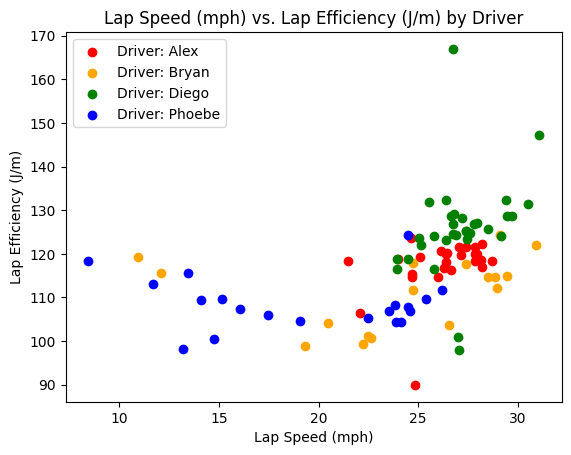

In [5]:
# Also from Jonah 
lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

for driver, colour in driver_colours.items():
    plt.scatter(lap_speeds[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Driver")
plt.show()

A quadratic relationship can be seen between `lap efficiency` and `average speed`, let's trying fitting a function to the data

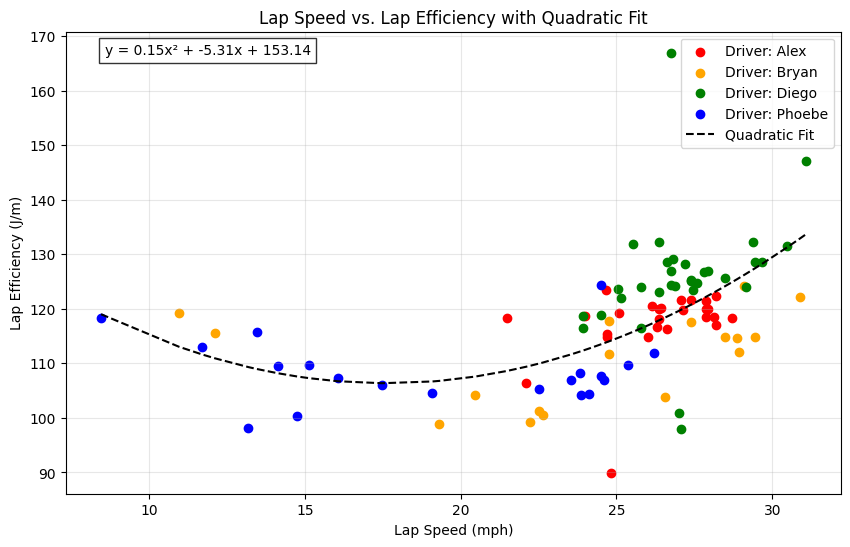

In [6]:
# Combine all data for the overall fit
all_speeds = np.array(lap_speeds)
all_efficiencies = np.array(lap_efficiencies)

# Sort data for plotting the fit line
sort_idx = np.argsort(all_speeds)
speeds_sorted = all_speeds[sort_idx]

# Define quadratic function for fitting
def quad_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function
popt, _ = curve_fit(quad_func, all_speeds, all_efficiencies)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual driver points
for driver, colour in driver_colours.items():
    mask = lap_drivers == driver
    plt.scatter(lap_speeds[mask], lap_efficiencies[mask],
                c=colour, label=f"Driver: {driver}")

# Plot the fitted curve
fit_y = quad_func(speeds_sorted, *popt)
plt.plot(speeds_sorted, fit_y, 'k--', label='Quadratic Fit')

# Add labels and title
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.title("Lap Speed vs. Lap Efficiency with Quadratic Fit")
plt.legend()

# Add the equation to the plot
equation = f'y = {popt[0]:.2f}x² + {popt[1]:.2f}x + {popt[2]:.2f}'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.show()

## Lap Efficiency and Average Battery Temp (C°)

Below are plots of `lap efficiency` and `average battery temp` in degrees celcius

In [7]:
lap_times = []
for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1

        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        lap_times.append((lap_start, lap_end))

In [8]:
battery_temps = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        battery_temp = data_client.query_time_series(lap_start, lap_end, "AverageTemp")    
        battery_temps.append(battery_temp.mean())

battery_temps = np.array(battery_temps)

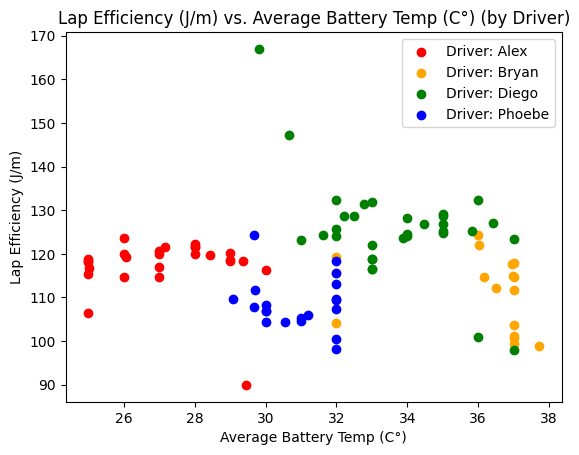

In [9]:
for driver, colour in driver_colours.items():
    plt.scatter(battery_temps[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Average Battery Temp (C°)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Average Battery Temp (C°) (by Driver)")
plt.show()

Checking to see if the battery temperature is being influenced by just warming up from being driven throughout the day. Which we come to see to be true from the graph below

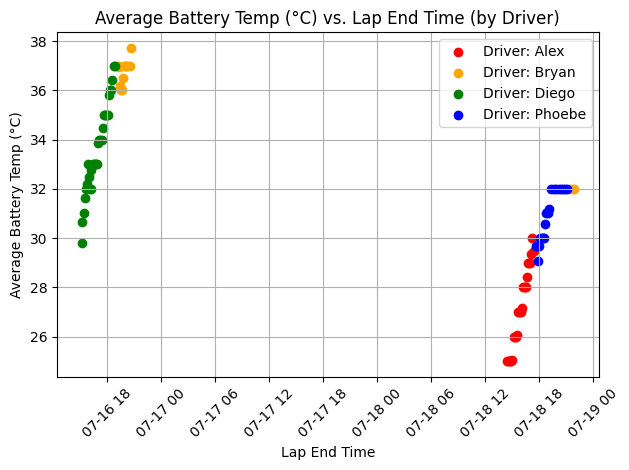

In [10]:
# Extract lap end times
lap_end_times = [lap_end for lap_start, lap_end in lap_times]

# Plot lap end times against average battery temperature
for driver, colour in driver_colours.items():
    plt.scatter(
        [lap_end_times[i] for i in range(len(lap_end_times)) if lap_drivers[i] == driver],
        [battery_temps[i] for i in range(len(battery_temps)) if lap_drivers[i] == driver],
        c=colour,
        label=f"Driver: {driver}"
    )

plt.xlabel("Lap End Time")
plt.ylabel("Average Battery Temp (°C)")
plt.legend()
plt.title("Average Battery Temp (°C) vs. Lap End Time (by Driver)")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Lap Efficiency and Average Wind Speed (m/s)

Below are plots of `lap efficiency` and `average wind speed` in m/s 

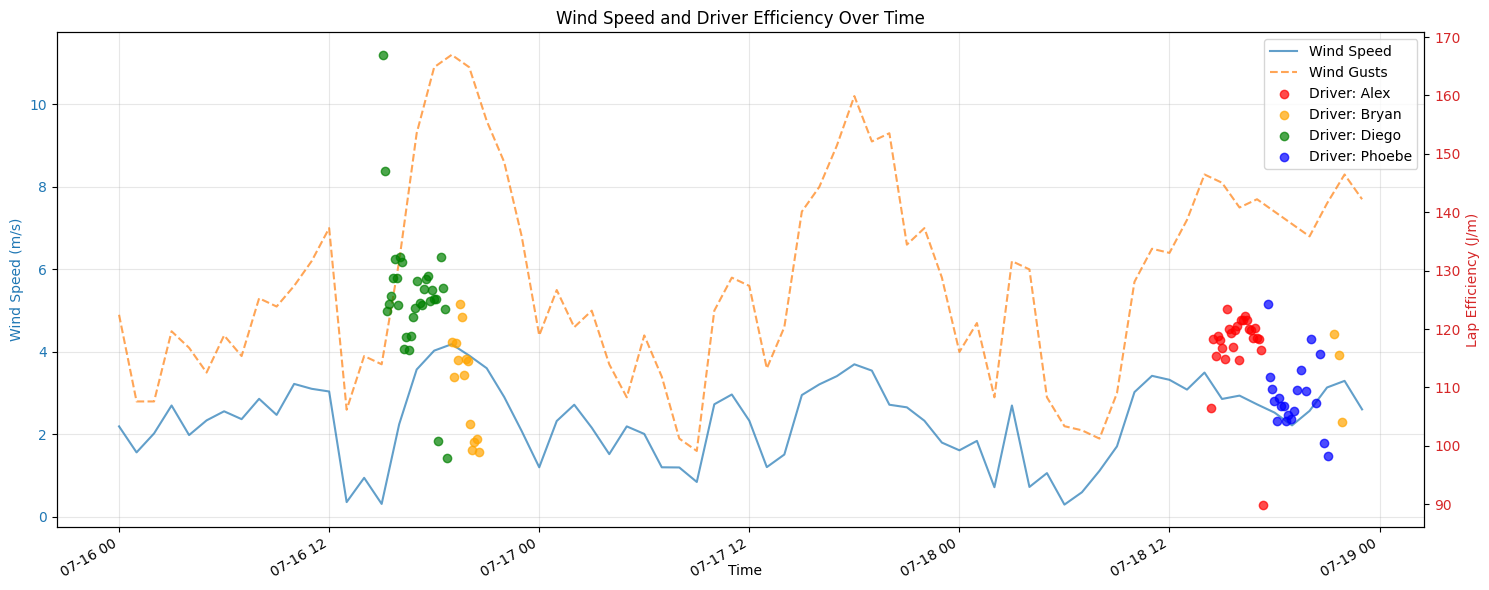

In [11]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def fetch_wind_data(latitude, longitude, start_date, end_date):
    """
    Fetch hourly wind speed data from Open-Meteo API
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["wind_speed_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms"  # Using m/s for scientific analysis
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    # Process hourly data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        ),
        "wind_speed": hourly.Variables(0).ValuesAsNumpy(),
        "wind_gusts": hourly.Variables(1).ValuesAsNumpy(),
    }
    
    return pd.DataFrame(data = hourly_data)

def plot_wind_analysis(df, lap_efficiencies, lap_times, lap_drivers):
    """
    Create a combined plot of wind data and driver efficiencies with two y-axes.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot wind data on primary y-axis (left)
    ax1.plot(df['date'], df['wind_speed'], label='Wind Speed', color='tab:blue', alpha=0.7)
    ax1.plot(df['date'], df['wind_gusts'], label='Wind Gusts', color='tab:orange', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Wind Speed (m/s)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    # Set up secondary y-axis for lap efficiencies (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Lap Efficiency (J/m)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Calculate lap midpoints for plotting
    lap_midpoints = [lap_start + (lap_end - lap_start) / 2 for lap_start, lap_end in lap_times]

    # Plot each driver's efficiencies on secondary y-axis
    for driver, color in driver_colours.items():
        mask = np.array(lap_drivers) == driver
        if np.any(mask):
            ax2.scatter(
                [lap_midpoints[i] for i in range(len(lap_midpoints)) if mask[i]],
                [lap_efficiencies[i] for i in range(len(lap_efficiencies)) if mask[i]],
                color=color,
                label=f"Driver: {driver}",
                alpha=0.7
            )
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Format x-axis to show dates nicely
    fig.text(0.5, 0.04, 'Time', ha='center', va='center')
    plt.title('Wind Speed and Driver Efficiency Over Time')
    plt.xlabel('Time')
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()


# lat lon for center of track
latitude = 37.00272354871939
longitude = -86.36671627935802
start_date = "2024-07-16"  # FSGP Day 1
end_date = "2024-07-18"    # FSGP Day 3

df = fetch_wind_data(latitude, longitude, start_date, end_date)
plot_wind_analysis(df, lap_efficiencies, lap_times, lap_drivers)

From the plot above its difficult to conclude if and how wind speeds has an effect on efficiency. There is room for more analysis.

## Lap Efficiency and Regen Energy (J)

Below are plots of `lap efficiency` and `total regen energy` in J 

In [12]:
def get_regen_energy(motor_power: TimeSeries) -> TimeSeries:
    """
    Calculate the regen energy for a given motor power time series.
    """
    # Calculate the regen energy by integrating the regen power
    regen_power = motor_power[motor_power < 0]
    if len(regen_power) == 0: # no regen power
        return 0.0
    regen_energy = np.cumsum(regen_power) * regen_power.granularity
 
    return abs(regen_energy[-1])

In [13]:
regen_energy = []
avg_motor_powers = []   # used later in the notebook
var_motor_powers = []   # used later in the notebook

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        motor_power = calculate_lap_power(lap_start, lap_end, data_client)
        avg_motor_powers.append(np.mean(motor_power))
        var_motor_powers.append(np.var(motor_power))
        regen_energy.append(get_regen_energy(motor_power))

regen_energy = np.array(regen_energy)
motor_powers = np.array(regen_energy)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 40, 21, tzinfo=datetime.timezone.utc)
start_time=date

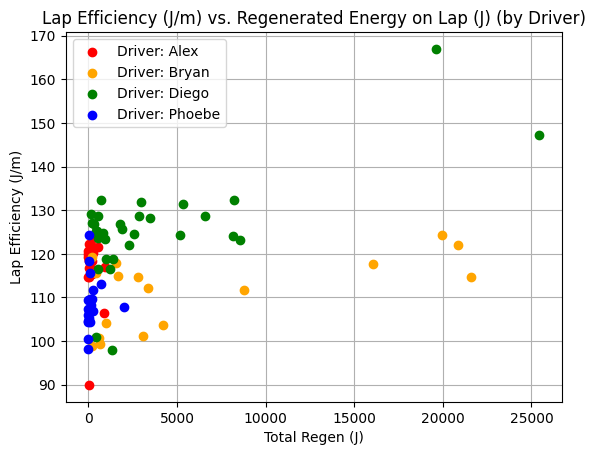

In [14]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.show()

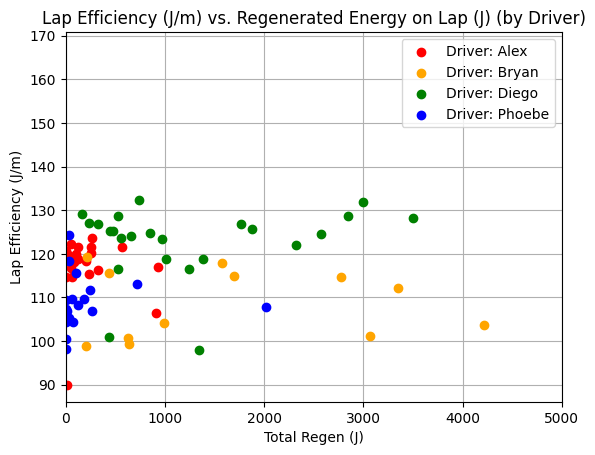

In [15]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.xlim(0, 5000)
plt.show()

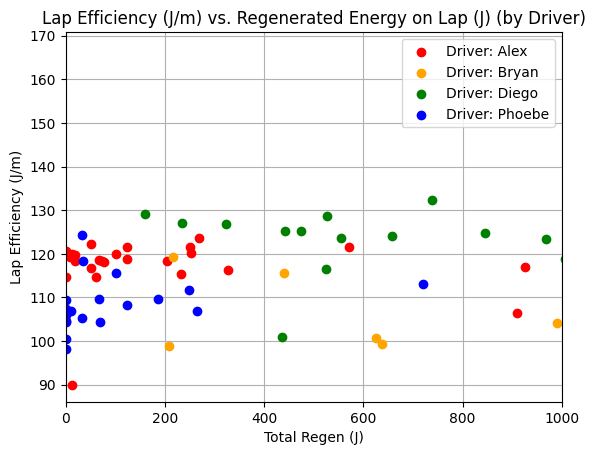

In [16]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.xlim(0, 1000)
plt.show()

Difficult to see if total regen energy has a direct correlation. Intuitively, it should since we get more energy back into the car but the trends look very flat, especially per driver. Could be that each driver's driving style is evening out the regen energy they produce?

## Lap Efficiency and Average Pack Current (A)

Below are plots of `lap efficiency` and `avg pack current` in A 

In [17]:
avg_pack_current = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        pack_currents = data_client.query_time_series(lap_start, lap_end, "PackCurrent")    
        avg_pack_current.append(pack_currents.mean())

avg_pack_current = np.array(avg_pack_current)

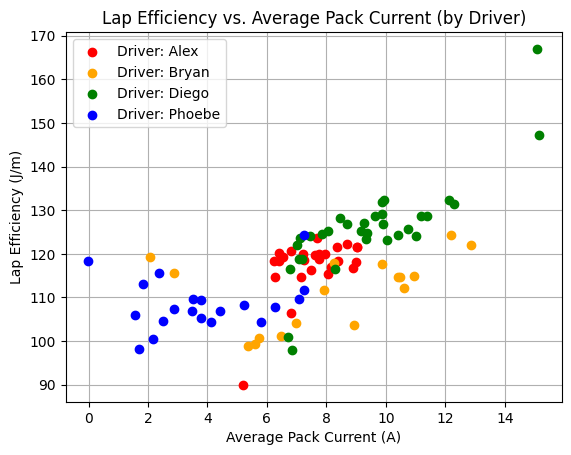

In [18]:
for driver, colour in driver_colours.items():
    plt.scatter(avg_pack_current[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Average Pack Current (A)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency vs. Average Pack Current (by Driver)")
plt.grid(zorder=1)  
plt.show()

We see some nice clustering showing a possible trend.

## Lap Efficiency and Average Motor Current (A)

Below are plots of `lap efficiency` and `avg motor current` in A 

In [19]:
avg_motor_current = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)

        raw_motor_current: TimeSeries = data_client.query_time_series(lap_start, lap_end, "BatteryCurrent")
        motor_current_dir: TimeSeries = data_client.query_time_series(lap_start, lap_end, "BatteryCurrentDirection")
            
        # Align x-axes
        raw_motor_current, motor_current_dir = TimeSeries.align(raw_motor_current, motor_current_dir)
        # Make direction -1 or 1 instead of 1 or 0
        motor_current_sign = motor_current_dir * -2 + 1

        # Account for regen direction
        motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
        avg_motor_current.append(motor_current.mean())

avg_motor_current = np.array(avg_motor_current)    

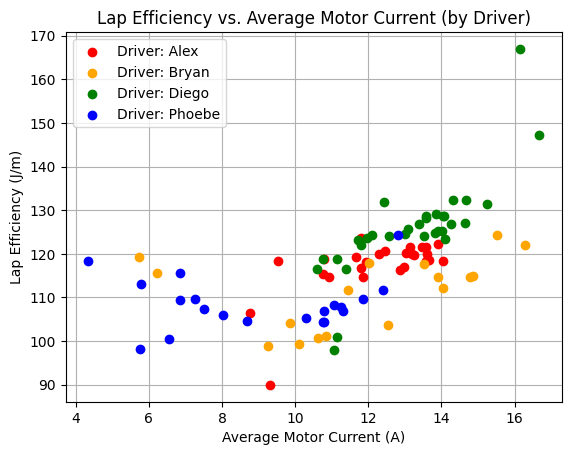

In [20]:
for driver, colour in driver_colours.items():
    plt.scatter(avg_motor_current[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Average Motor Current (A)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency vs. Average Motor Current (by Driver)")
plt.grid(zorder=1)  
plt.show()

Again we see a similar curve trend as seen with `average speed` and `average pack current`.

## Correlation Analysis

By now, we have an idea of what kinds of trends we see and what factors we're interested in when it comes to finding what makes for an efficient lap. Although the analysis thus far had a slight focus on factors as well as drivers, we want to analyze our data as a whole to come to a conclusion. Therefore, we give less of an attention to who drive the lap, and more attention to the data points themself.  

*Start by accumulating some more data of interest to find correlation*

The following functions are adapted from Jonah Lee's [Notebook](motor_analysis\lap_efficiency_jonah.ipynb)

In [21]:
def lap_speed_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    lap_speed: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity")

    lap_speed.units = "m/s"
    lap_speed.meta["field"] = "Speed"
    return lap_speed

In [22]:
lap_distances = []                      #lap distances in meters
lap_speed_vars = []                     #lap speed variances

lap_avg_acceleration = []               #lap average acceleration
lap_var_acceleration = []               #lap variance of acceleration

lap_accleorator_pos = []                #lap accelerator positions
lap_accleorator_pos_vars = []           #lap accelerator positions variances


for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)

        # Get speed data for the lap
        speed_array: TimeSeries = lap_speed_ts(lap_start, lap_end, data_client)
        lap_distances.append(np.sum(speed_array) * speed_array.granularity)
        lap_speed_vars.append(np.var(speed_array))

        # Get acceleration data for the lap
        accelerations = np.diff(speed_array) / speed_array.granularity
        lap_avg_acceleration.append(np.mean(accelerations))
        lap_var_acceleration.append(np.var(accelerations))

        # Get accelerator position data for the lap
        accelerator_positions: TimeSeries = data_client.query_time_series(lap_start, lap_end, "AcceleratorPosition")
        lap_accleorator_pos.append(np.mean(accelerator_positions))
        lap_accleorator_pos_vars.append(np.var(accelerator_positions))


Create a Dataframe for ease of analysis

In [112]:
# Create a DataFrame from these arrays
data = {
    'Distance (m)': lap_distances,
    'Speed Var': lap_speed_vars,
    'Avg Acceleration (m/s^2)': lap_avg_acceleration,
    'Acceleration Var': lap_var_acceleration,
    'Avg Accelorator Position (%)': lap_accleorator_pos,
    'Accelorator Position Var': lap_accleorator_pos_vars,
    'Avg Motor Current (A)': avg_motor_current,
    'Avg Motor Power (W)': avg_motor_powers,
    'Motor Power Var': var_motor_powers,
    'Avg Pack Current (A)': avg_pack_current,
    'Regened Energy (J)': regen_energy,
    'Energy (J)': lap_energies,
    'Avg Battery Temp (C)': battery_temps,
    'Avg Speed (mph)': lap_speeds,
    'Driver': lap_drivers
}

# Convert the dictionary to a DataFrame
dataframe = pd.DataFrame(data)

In [113]:
# Display the first 10 rows of the DataFrame
dataframe.head(10)

,Distance (m),Speed Var,Avg Acceleration (m/s^2),Acceleration Var,Avg Accelorator Position (%),Accelorator Position Var,Avg Motor Current (A),Avg Motor Power (W),Motor Power Var,Avg Pack Current (A),Regened Energy (J),Energy (J),Avg Battery Temp (C),Avg Speed (mph),Driver
0,5425.417711959088,10.87254858065726,0.020485271058891055,0.37557418064416215,45.90867216484904,1331.1183650608573,16.160522,1996.8692669527322,4302914.759721627,15.087938,19598.162530,846444.926404,29.816711,26.745,Diego
1,5121.933540992318,2.7063311230326206,0.00020954573146622342,0.3582454356376869,45.76665469880027,1509.3745998505535,16.675538,2045.4049729697833,4820673.612847696,15.158729,25437.545953,745938.739222,30.666164,31.068,Diego
2,5098.6438243688335,1.1810729711406096,-0.001344503735075272,0.19822491571156145,39.10766501998863,585.6232103902596,11.720337,1452.6386111652437,1816448.8907813928,10.053067,8538.325456,624473.359827,31.000000,26.372,Diego
3,5182.615597100614,1.8953857772669802,0.000871745250062681,0.21421266535838462,39.52472664520134,705.2474924765329,12.111675,1493.1607350011066,2094671.0225491992,10.422438,5174.789069,629948.089238,31.618735,26.872,Diego
4,5125.517488677095,1.9260760163049386,-0.0016452473919458122,0.22280609518153102,39.85707241863043,900.1869601993164,13.089525,1601.1379312097506,2806871.2301712697,10.729242,1872.942775,636756.543954,32.000000,28.492,Diego
5,5158.282976121215,1.7623026742972048,0.0007462273139359707,0.24983968719997746,42.29950030299593,947.1504971587328,14.038374,1708.2925412691218,3003523.1793914703,11.197077,2847.644198,652379.838357,32.211358,29.686,Diego
6,5282.060546246367,9.70929610338253,0.0003378692819096354,0.24296378336741214,37.43883840888955,988.192571707606,12.436989,1507.6883183735142,2943246.5450123176,9.854278,2997.922707,669096.998753,33.000000,25.541,Diego
7,5162.499252688673,1.590199867947416,0.0006040324778782311,0.23899169484275753,42.77680511632106,890.5942231272895,14.081707,1695.8446049191662,2751281.8508679513,11.380539,6564.777793,652374.461163,32.498697,29.455,Diego
8,5117.129604128573,1.34268114080724,-0.0005977936961437235,0.23713437439389987,42.362514792926454,968.8702257347634,13.531487,1617.9955121060893,2895092.0658449153,11.015601,8135.558088,629062.092968,32.000000,29.152,Diego
9,5161.095292256347,1.2264604025431944,0.002107413353401825,0.28142879209528615,43.07523568942439,1193.912669819474,14.673440,1739.137429827297,3407832.5103135942,12.139669,8200.832943,670943.567998,32.000000,29.378,Diego


With all this data gathered we will begin with a [Pearson Correlation Matrix](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [114]:
from sklearn.preprocessing import LabelEncoder

# Since the driver names are strings, we need to encode them as integers for the correlation matrix
encoder = LabelEncoder()

# Filter out laps with short distances to get rid of laps where we pit and come out of pitting
filtered_df = dataframe[(dataframe['Distance (m)'] >= 5000) & (dataframe['Distance (m)'] <= 5200)]

encoded_df = filtered_df.copy()
encoded_df['Driver'] = encoder.fit_transform(filtered_df['Driver'])
encoded_df.head(10)

,Distance (m),Speed Var,Avg Acceleration (m/s^2),Acceleration Var,Avg Accelorator Position (%),Accelorator Position Var,Avg Motor Current (A),Avg Motor Power (W),Motor Power Var,Avg Pack Current (A),Regened Energy (J),Energy (J),Avg Battery Temp (C),Avg Speed (mph),Driver
1,5121.933540992318,2.7063311230326206,0.00020954573146622342,0.3582454356376869,45.76665469880027,1509.3745998505535,16.675538,2045.4049729697833,4820673.612847696,15.158729,25437.545953,745938.739222,30.666164,31.068,2
2,5098.6438243688335,1.1810729711406096,-0.001344503735075272,0.19822491571156145,39.10766501998863,585.6232103902596,11.720337,1452.6386111652437,1816448.8907813928,10.053067,8538.325456,624473.359827,31.000000,26.372,2
3,5182.615597100614,1.8953857772669802,0.000871745250062681,0.21421266535838462,39.52472664520134,705.2474924765329,12.111675,1493.1607350011066,2094671.0225491992,10.422438,5174.789069,629948.089238,31.618735,26.872,2
4,5125.517488677095,1.9260760163049386,-0.0016452473919458122,0.22280609518153102,39.85707241863043,900.1869601993164,13.089525,1601.1379312097506,2806871.2301712697,10.729242,1872.942775,636756.543954,32.000000,28.492,2
5,5158.282976121215,1.7623026742972048,0.0007462273139359707,0.24983968719997746,42.29950030299593,947.1504971587328,14.038374,1708.2925412691218,3003523.1793914703,11.197077,2847.644198,652379.838357,32.211358,29.686,2
7,5162.499252688673,1.590199867947416,0.0006040324778782311,0.23899169484275753,42.77680511632106,890.5942231272895,14.081707,1695.8446049191662,2751281.8508679513,11.380539,6564.777793,652374.461163,32.498697,29.455,2
8,5117.129604128573,1.34268114080724,-0.0005977936961437235,0.23713437439389987,42.362514792926454,968.8702257347634,13.531487,1617.9955121060893,2895092.0658449153,11.015601,8135.558088,629062.092968,32.000000,29.152,2
9,5161.095292256347,1.2264604025431944,0.002107413353401825,0.28142879209528615,43.07523568942439,1193.912669819474,14.673440,1739.137429827297,3407832.5103135942,12.139669,8200.832943,670943.567998,32.000000,29.378,2
10,5141.047268245204,1.6117121249824733,-0.0009356027912734263,0.28300497114905887,44.00375696380403,1164.7649643596787,15.234704,1792.4156690593709,3510676.619098089,12.295151,5345.473278,666583.255640,32.777552,30.484,2
11,5090.493108261697,1.7840324490616708,-0.00484984238038826,0.1834428476533414,36.15836123620244,814.049779519245,11.388389,1343.8754219059185,2207482.3933776654,8.278768,1246.203621,591021.627971,33.000000,25.773,2


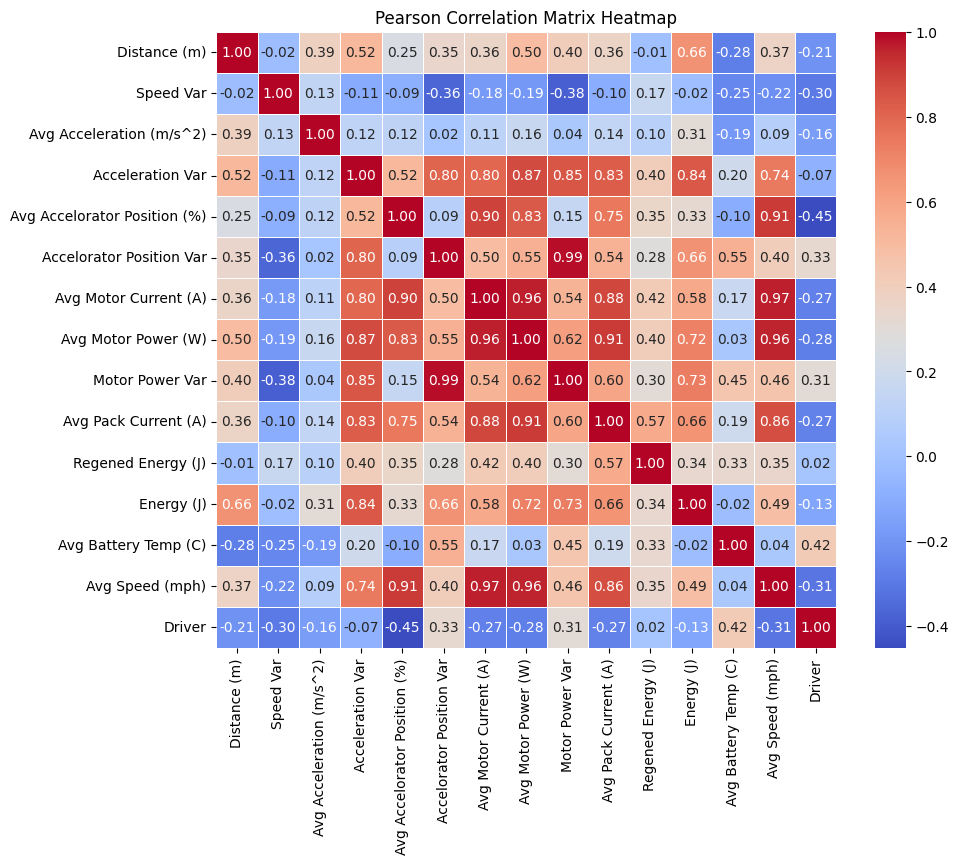

In [115]:
import seaborn as sns

# Calculate the Pearson correlation matrix
correlation_matrix = encoded_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Matrix Heatmap")
plt.show()

Visualizing a reduced matrix to isolate feature with higher correlation, also removing columns with high collinearity.

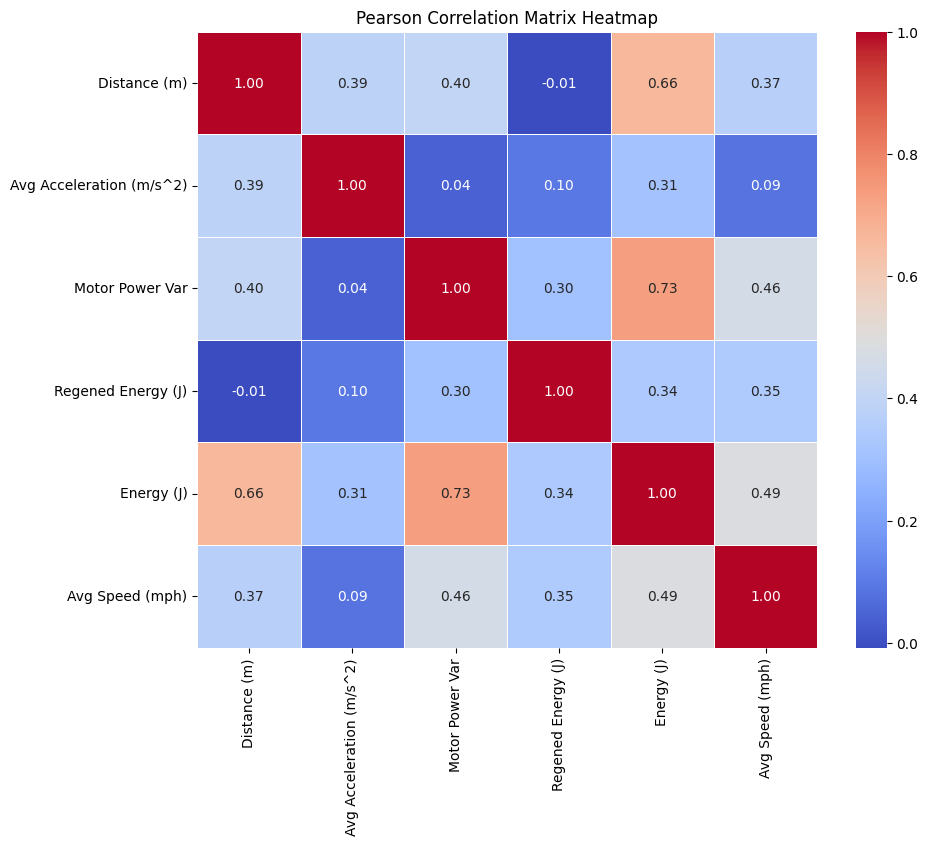

In [116]:
reduced_encoded_df = encoded_df.drop(columns=['Avg Motor Power (W)', 
                                              'Acceleration Var', 
                                              'Accelorator Position Var', 
                                              'Speed Var', 
                                              'Avg Pack Current (A)', 
                                              'Avg Motor Current (A)', 
                                              'Avg Battery Temp (C)', 
                                              'Avg Accelorator Position (%)',
                                              'Driver'])


reduced_correlation_matrix = reduced_encoded_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Matrix Heatmap")
plt.show()

Below is another reduced correlation matrix with features that we/the driver could better control for in the moment during a race.

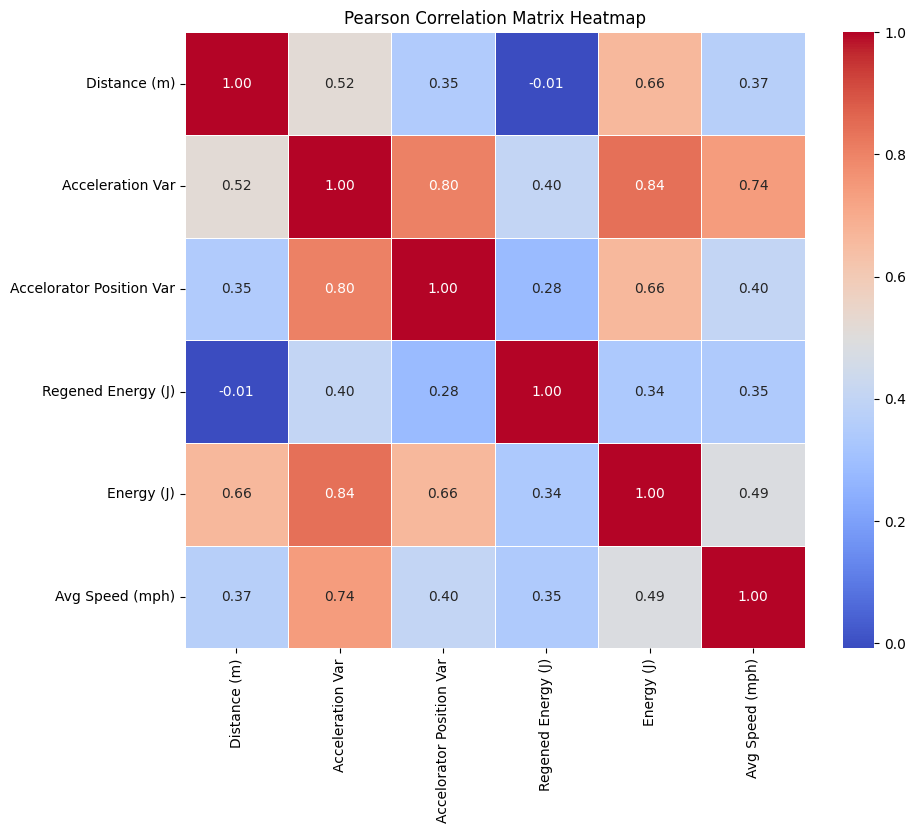

In [117]:
controllable_features_df = encoded_df[["Distance (m)", 
                                 "Acceleration Var", 
                                 "Accelorator Position Var", 
                                 "Regened Energy (J)", 
                                 "Energy (J)", 
                                 "Avg Speed (mph)"]]


controllable_correlation_matrix = controllable_features_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(controllable_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Matrix Heatmap")
plt.show()

### Future Analyis
For simplicity, use the functions below to pass in a previously generated dataframe and a feature to create a relationship plot with that feature and energy.

In [124]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def analyze_correlations(df, target_col='energy', max_degree=5):
    """
    Analyze both linear and nonlinear correlations between features and target column.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    target_col (str): Name of the target column (default: 'energy')
    max_degree (int): Maximum polynomial degree to test (default: 3)
    
    Returns:
    pandas.DataFrame: Correlation analysis results
    """
    results = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col == target_col:
            continue
            
        # Remove any missing values
        valid_data = df[[col, target_col]].dropna()
        x = valid_data[col].values.reshape(-1, 1)
        y = valid_data[target_col].values
        
        # Linear correlation (Pearson)
        pearson_corr, _ = stats.pearsonr(x.ravel(), y)
        
        # Spearman rank correlation (monotonic relationships)
        spearman_corr, _ = stats.spearmanr(x.ravel(), y)
        
        # Polynomial regression analysis
        best_r2 = 0
        best_degree = 1
        
        for degree in range(1, max_degree + 1):
            poly_features = PolynomialFeatures(degree=degree)
            x_poly = poly_features.fit_transform(x)
            
            model = LinearRegression()
            model.fit(x_poly, y)
            
            r2 = r2_score(y, model.predict(x_poly))
            
            if r2 > best_r2:
                best_r2 = r2
                best_degree = degree
        
        results.append({
            'feature': col,
            'pearson_correlation': abs(pearson_corr),
            'spearman_correlation': abs(spearman_corr),
            'best_polynomial_r2': best_r2,
            'best_polynomial_degree': best_degree,
            'relationship_type': 'Nonlinear' if (best_degree > 1 and best_r2 > abs(pearson_corr)**2) else 'Linear'
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values('best_polynomial_r2', ascending=False)

def plot_relationship(df, feature_col, target_col='energy'):
    """
    Plot the relationship between a feature and the target variable.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    feature_col (str): Name of the feature column
    target_col (str): Name of the target column (default: 'energy')
    """
    import matplotlib.pyplot as plt
    
    x = df[feature_col].values.reshape(-1, 1)
    y = df[target_col].values
    
    # Fit polynomial regression
    poly_features = PolynomialFeatures(degree=3)
    x_poly = poly_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    
    # Sort points for smooth curve
    sort_idx = np.argsort(x.ravel())
    x_sorted = x[sort_idx]
    y_pred = model.predict(poly_features.transform(x_sorted))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x_sorted, y_pred, 'r-', label='Polynomial fit')
    plt.xlabel(feature_col)
    plt.ylabel(target_col)
    plt.title(f'Relationship between {feature_col} and {target_col}')
    plt.legend()
    plt.show()

                 feature  pearson_correlation  spearman_correlation  \
5                 Driver             0.128322              0.104878   
0  Avg Motor Current (A)             0.580189              0.671292   
1   Avg Pack Current (A)             0.656285              0.667831   
4        Avg Speed (mph)             0.487372              0.637530   
3   Avg Battery Temp (C)             0.021561              0.062823   
2     Regened Energy (J)             0.335427              0.345149   

   best_polynomial_r2  best_polynomial_degree relationship_type  
5            0.612765                       3         Nonlinear  
0            0.578225                       5         Nonlinear  
1            0.571003                       5         Nonlinear  
4            0.538594                       5         Nonlinear  
3            0.355685                       5         Nonlinear  
2            0.204407                       4         Nonlinear  


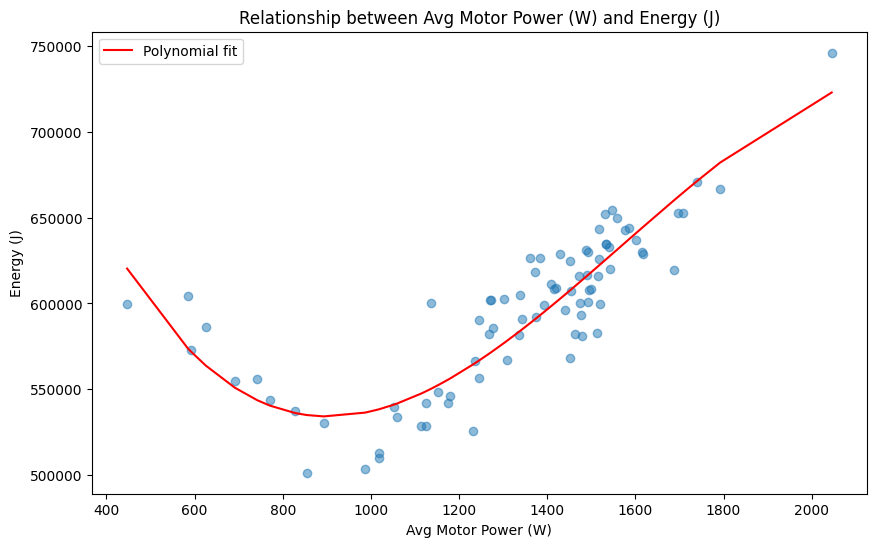

In [125]:
# Example usage
results = analyze_correlations(encoded_df, target_col='Energy (J)')
print(results)

# To visualize a specific relationship
plot_relationship(encoded_df, 'Avg Motor Power (W)', 'Energy (J)')